#### EMACS LISP STUFF PLEASE IGNORE
(defun switch-to-notebook ()
 (interactive)
 (st-toggle-to-buffer "*ein: http://127.0.0.1:8899/make_figs.ipynb*"))

In [257]:
%pylab inline
import os,sys,re
import pickle
from copy import deepcopy
from builtins import sum as bsum
from importlib import reload
from collections import defaultdict, namedtuple
from matplotlib.gridspec import GridSpec
import matplotlib.transforms as mtransforms
plt.style.use("default")
plt.rcParams["figure.figsize"] = (8,3)
flush = lambda *args, **kwargs: [sys.stdout.flush(), print(*args, **kwargs)]

Populating the interactive namespace from numpy and matplotlib


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f', 'yticks', 'xticks', 'box', 'axes']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [258]:
os.environ["FISHER_PLUMES"] = os.path.join(os.environ["GIT"],"fisher-plumes")
os.chdir(os.environ["FISHER_PLUMES"])

In [259]:
# Don't reload this, otherwise it will create a new units registry object
# and will then complain about combining different registries.
import units; reload(units); UNITS = units.UNITS; 

In [260]:
import boulder;   reload(boulder)
import crick;     reload(crick)
import surrogate; reload(surrogate)
import fisher_plumes_tools as fpt;      reload(fpt)
import fisher_plumes_figs  as fpf;      reload(fpf);
import fisher_plumes_fig_tools as fpft; reload(fpft)
import fisher_plumes as fp;             reload(fp)
import utils; reload(utils); from utils import dict_update, dict_update_from_field
import proc; reload(proc);
FisherPlumes = fp.FisherPlumes
crick.logger.setLevel(logging.DEBUG)
fp.logger.setLevel(logging.INFO)


INFO:boulder:Boulder simulation data available for:


INFO:boulder:Re100_0_5mm_50Hz_16source_manuscript.h5         : ['Odor Data/c1a', 'Odor Data/c1b', 'Odor Data/c2a', 'Odor Data/c2b', 'Odor Data/c3a', 'Odor Data/c3b', 'Odor Data/c4a', 'Odor Data/c4b', 'Odor Data/c5a', 'Odor Data/c5b', 'Odor Data/c6a', 'Odor Data/c6b', 'Odor Data/c7a', 'Odor Data/c7b', 'Odor Data/c8a', 'Odor Data/c8b'] (16 datasets)


INFO:crick:Simulation data available for:


INFO:crick:crimgrid_w1                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w2                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w3                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w4                                     : y0 - y9 (16 datasets)


INFO:crick:n12T                                            : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n12Tslow                                        : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n12dishT                                        : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n16T                                            : Y0.440 - Y0.560 (16 datasets)


INFO:crick:n16Tslow                                        : Y0.440 - Y0.560 (16 datasets)


INFO:surrogate:Surrogate simulation data available for: ['no_info', 'one_info', 'two_info', 'high', 'spike_and_slab', 'blue', 'red', 'all_equal']


# Specify the analysis window

In [261]:
window_length = 1 * UNITS.second
window_shape  = ('boxcar')
fit_k         = True

# Specify the datasets to use

In [262]:
to_use = {"16Ts":{"sim_name":"n16Tslow"},
          "bw":  {"sim_name":"boulder16"},
          "s=p": {"sim_name":"surr_all_equal"},
          "shw": {"sim_name":"surr_high",      "surrogate_k": 0},          
          "shp": {"sim_name":"surr_high",      "surrogate_k": 4}}

# Load the data

In [263]:
[f.logger.setLevel(logging.WARN) for f in [crick, boulder,fp]];

data =  {k:FisherPlumes(proc.load_data(init_filter = v,
                                       compute_filter = {"window_shape":window_shape,
                                                         "window_length":window_length,
                                                         "fit_k":fit_k}
)[0]) for k,v in to_use.items()}

[f.logger.setLevel(logging.INFO) for f in [crick, boulder,fp]];


                    proc 2023/07/08 15:17:52     INFO: Loading init_filter={'sim_name': 'n16Tslow'} compute_filter={'window_shape': 'boxcar', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/n16Ts.1/84454dd2e6a4f16a.p


                    proc 2023/07/08 15:17:53     INFO: Returning 1 results.


                    proc 2023/07/08 15:17:54     INFO: Loading init_filter={'sim_name': 'boulder16'} compute_filter={'window_shape': 'boxcar', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/bw.1/bcd66de2fac76f01.p


                    proc 2023/07/08 15:17:54     INFO: Returning 1 results.


                    proc 2023/07/08 15:17:55     INFO: Loading init_filter={'sim_name': 'surr_all_equal'} compute_filter={'window_shape': 'boxcar', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/su.1/2d4749e757f4ae59.p


                    proc 2023/07/08 15:17:55     INFO: Returning 1 results.


INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@or

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@or

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@or

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@or

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@or

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@or

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@or

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@or

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@orig

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@orig

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@ori

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@ori

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@ori

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@ori

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@ori

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@ori

                    proc 2023/07/08 15:17:55     INFO: Loading init_filter={'sim_name': 'surr_high', 'surrogate_k': 0} compute_filter={'window_shape': 'boxcar', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.1/0bdbc418ca8e3f5e.p


                    proc 2023/07/08 15:17:55     INFO: Returning 1 results.


INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-20.99838178],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-20.99838178],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ -7.92263259],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ -4.45896517],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ -2.4916727 ],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-27.87325508],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ 13.81625708],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-17.05344673],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ -4.62597823],
       

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ 32.35989745],
       [-

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[  30.78765427],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ 16.24258983],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ -4.24927386],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[  9.73885561],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-12.50512481],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-64.27818861],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-50.72101405],
      

                    proc 2023/07/08 15:17:56     INFO: Loading init_filter={'sim_name': 'surr_high', 'surrogate_k': 4} compute_filter={'window_shape': 'boxcar', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.1/d5a72a043f07234f.p


                    proc 2023/07/08 15:17:56     INFO: Returning 1 results.


INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-0.84585665],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-0.84585665],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-1.01859563],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-8.25499466],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-5.46857418],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-8.9488669 ],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-13.84395744],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-14.33092166],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-10.39051919],
       

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-13.90236359],
       [-

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-14.94112048],
       

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-13.85379337],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ -7.62470057],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-5.76858384],
       

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-7.85668297],
       

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-1.71759623],
       

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-6.95028672],
       

# Whether to save the plots we make and where to put them

In [264]:
SAVEPLOTS = True # Whether to actually make the plots
fig_dir_full        = fpft.get_fig_dir(window_shape = window_shape, window_length = window_length, fit_k = fit_k, create = True); print(f"{fig_dir_full=}")
fig_dir_wnd_shp_len = fpft.get_fig_dir(window_shape = window_shape, window_length = window_length, fit_k = None,  create = True); print(f"{fig_dir_wnd_shp_len=}")
fig_dir_wnd_shp     = fpft.get_fig_dir(window_shape = window_shape, window_length = None,          fit_k = None,  create = True); print(f"{fig_dir_wnd_shp=}")
fig_dir_top         = fpft.get_fig_dir(window_shape = None,         window_length = None,          fit_k = None,  create = True); print(f"{fig_dir_top=}")
fig_dir_fitk        = fpft.get_fig_dir(window_shape = None,         window_length = None,          fit_k = fit_k, create = True); print(f"{fig_dir_fitk=}")

fig_dir_full='figs/boxcar/1s/fit_k=True'
fig_dir_wnd_shp_len='figs/boxcar/1s'
fig_dir_wnd_shp='figs/boxcar'
fig_dir_top='figs'
fig_dir_fitk='figs/fit_k=True'


# Figure showing an example plume and correlations

In [265]:
DEFAULT   = "default"
isdefault = lambda x: type(x) is str and x == DEFAULT

su_ds = [k for k,v in to_use.items() if v["sim_name"].startswith("surr")]
surrQ = lambda x: x in su_ds
print(f"Surrogate datasets = {su_ds}.")

which_srcs   = dict_update_from_field({"bw":[-3750, 3750],
                                       "cr":[490000,510000],
                                       "w1":[107300, 114700], "w2":[218300,225700], "w3":[329300,336700],"w4":[440300,447700],
                                       "12T":[498000,502000], "12Ts":[498000,502000],
                                       "16T":[496000,504000], "16Ts":[496000,504000],
},       
                                      su_ds, "bw")        
t_wnd        = dict_update_from_field({"bw":[-4,4]*UNITS.sec,     "cr":[-0.5, 0.5]*UNITS.sec}, su_ds + ["w1","w2","w3","w4","12T","12Ts","16T","16Ts"], "bw")
which_idists = dict_update_from_field({"bw":[0,2,3],              "cr":[0,10,20]},             su_ds + ["w1","w2","w3","w4","12T","12Ts","16T","16Ts"], "bw")
tticks       = dict_update_from_field({"bw":DEFAULT,              "cr":[39.5,40,40.5]},        su_ds + ["w1","w2","w3","w4","12T","12Ts","16T","16Ts"], "bw")
xticks       = dict_update_from_field({"bw":DEFAULT,              "cr":DEFAULT},               su_ds + ["w1","w2","w3","w4","12T","12Ts","16T","16Ts"], "bw")
yticks       = dict_update_from_field({"bw":DEFAULT,              "cr":DEFAULT},               su_ds + ["w1","w2","w3","w4","12T","12Ts","16T","16Ts"], "bw")
snapshot_time = defaultdict(lambda: 40000*UNITS.ms, {"12T":10001*UNITS.ms, "12Ts":40010*UNITS.ms,"16T":10001*UNITS.ms, "16Ts":40010*UNITS.ms})

Surrogate datasets = ['s=p', 'shw', 'shp'].


[440000, 448000, 456000, 464000, 472000, 480000, 488000, 496000, 504000, 512000, 520000, 528000, 536000, 544000, 552000, 560000]


      fisher_plumes_figs 2023/07/08 15:17:57     INFO: Clipped snapshots to limsx=array([ 42, 488]), limsy=array([ 33, 405]).


Wrote figs/boxcar/1s/plumes_demo_16Ts.pdf.


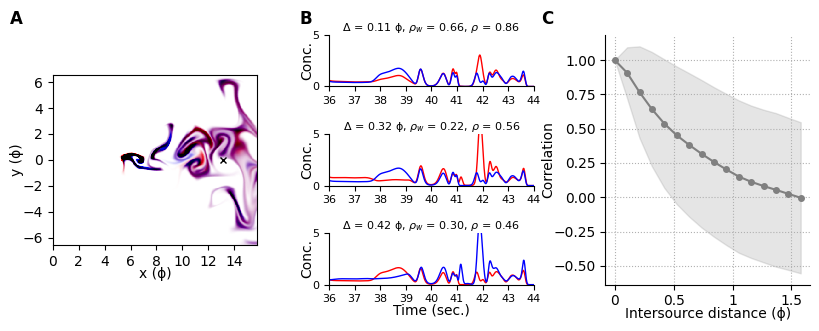

INFO:boulder:Loading fld='c1a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c1a_t40.p'.


INFO:boulder:Loading fld='c1b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c1b_t40.p'.


INFO:boulder:Loading fld='c2a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c2a_t40.p'.


INFO:boulder:Loading fld='c2b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c2b_t40.p'.


INFO:boulder:Loading fld='c3a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c3a_t40.p'.


INFO:boulder:Loading fld='c3b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c3b_t40.p'.


INFO:boulder:Loading fld='c4a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c4a_t40.p'.


INFO:boulder:Loading fld='c4b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c4b_t40.p'.


INFO:boulder:Loading fld='c5a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c5a_t40.p'.


INFO:boulder:Loading fld='c5b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c5b_t40.p'.


INFO:boulder:Loading fld='c6a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c6a_t40.p'.


INFO:boulder:Loading fld='c6b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c6b_t40.p'.


INFO:boulder:Loading fld='c7a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c7a_t40.p'.


INFO:boulder:Loading fld='c7b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c7b_t40.p'.


INFO:boulder:Loading fld='c8a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c8a_t40.p'.


INFO:boulder:Loading fld='c8b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c8b_t40.p'.


Wrote figs/boxcar/1s/plumes_demo_bw.pdf.


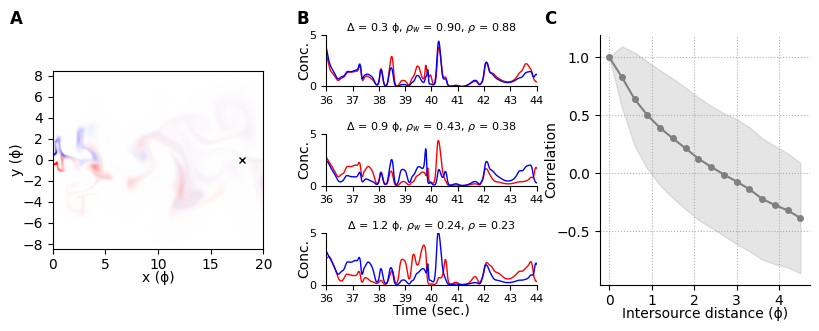

In [266]:
reload(fpf)
reload(fpft)

for k, F in sorted(data.items()):
    if surrQ(k): continue
    ax_plume, ax_traces, ax_corr = fpf.plot_plumes_demo(F, snapshot_time[k], which_srcs[k],
                                                    t_center = (snapshot_time[k].to(UNITS.ms).magnitude//1000)*1000 * UNITS.ms,
                                                    y_lim = (0,5.01) if not surrQ(k) else (-3.01,3.01), y_ticks = [-3,0,3] if surrQ(k) else None,
                                                        data_dir = os.path.join(boulder.data_root, "saved-snapshots") if k == "bw" else None,
                                                    t_wnd = t_wnd[k], dt = 1 * UNITS.sec, which_idists=which_idists[k])
    not isdefault(tticks[k]) and ax_traces[-1].set_xticks(tticks[k])    
    not isdefault(xticks[k]) and ax_plume.set_xticks(xticks[k])
    not isdefault(yticks[k]) and ax_plume.set_yticks(yticks[k])
    if surrQ(k) or k  in ["bw"]: ax_corr.set_xticks(arange(5))
    if surrQ(k): [ax_corr.set_ylim(-0.85,1.05), ax_corr.set_ylabel("Correlation",labelpad=-8)]
    fpft.label_axes([ax_plume, ax_traces[0], ax_corr], "ABC", y = [0.99]*3, fontsize=12, fontweight="bold")
    file_name = f"{fig_dir_wnd_shp_len}/plumes_demo_{k}.pdf"
    #ax_corr.set_ylim(-0.5,1.02)
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()

# Set the probe index we'll use

In [267]:
iprb = 0

# Figure showing the distribution of correlations

16Ts
Mapped frequencies [ 1  2  3 17 20] Hz to indices [1, 2, 3, 17, 20].


Wrote figs/boxcar/1s/corr_components_16Ts.pdf.


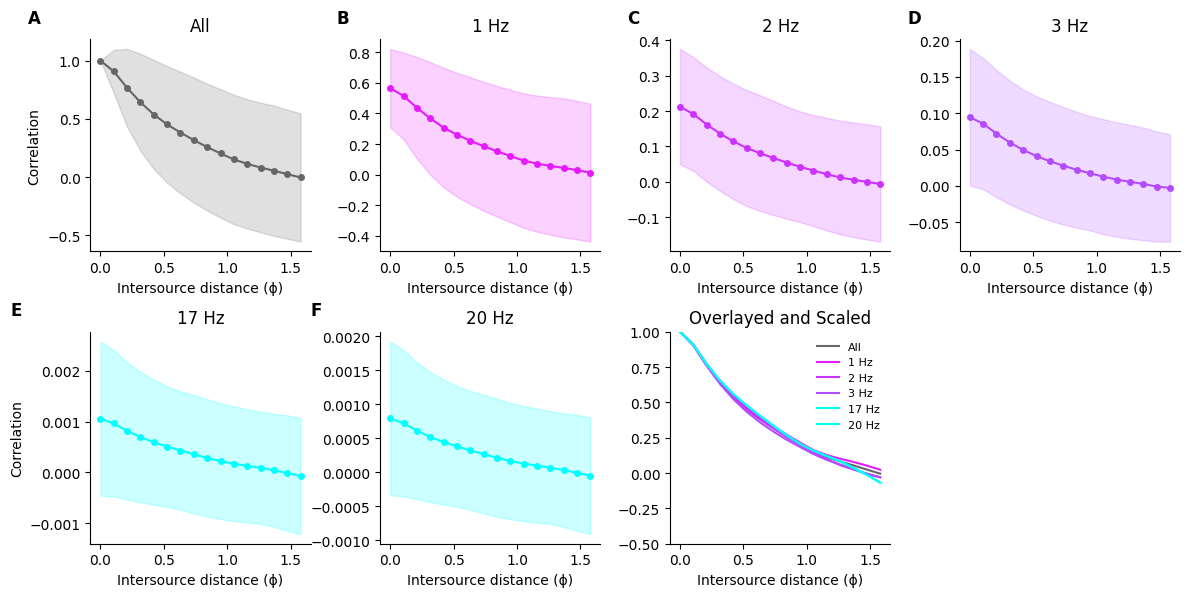

bw
Mapped frequencies [ 1  2  3 17 20] Hz to indices [1, 2, 3, 17, 20].


Wrote figs/boxcar/1s/corr_components_bw.pdf.


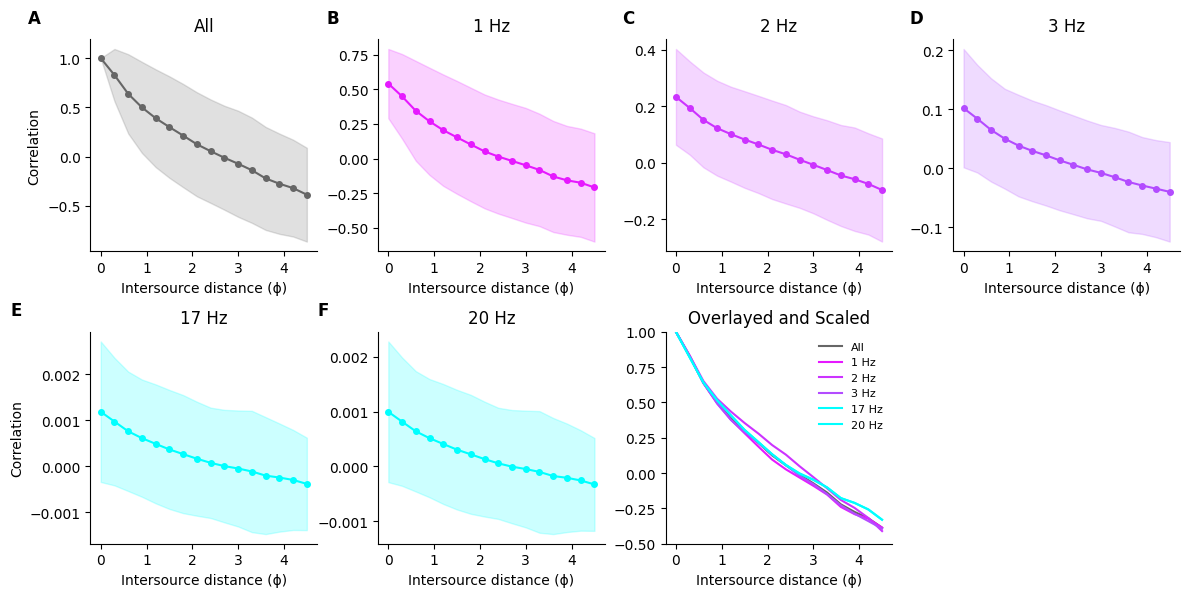

s=p
Mapped frequencies [ 1  2  3 17 20] Hz to indices [1, 2, 3, 17, 20].


Wrote figs/boxcar/1s/corr_components_s=p.pdf.


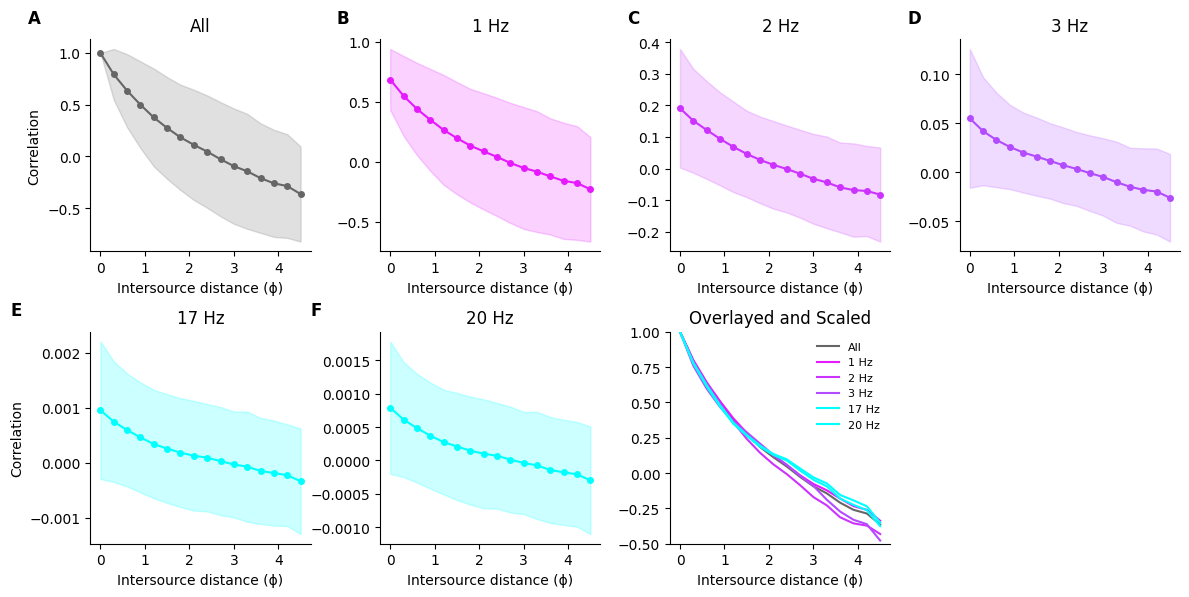

shw
Mapped frequencies [ 1  2  3 17 20] Hz to indices [1, 2, 3, 17, 20].


Wrote figs/boxcar/1s/corr_components_shw.pdf.


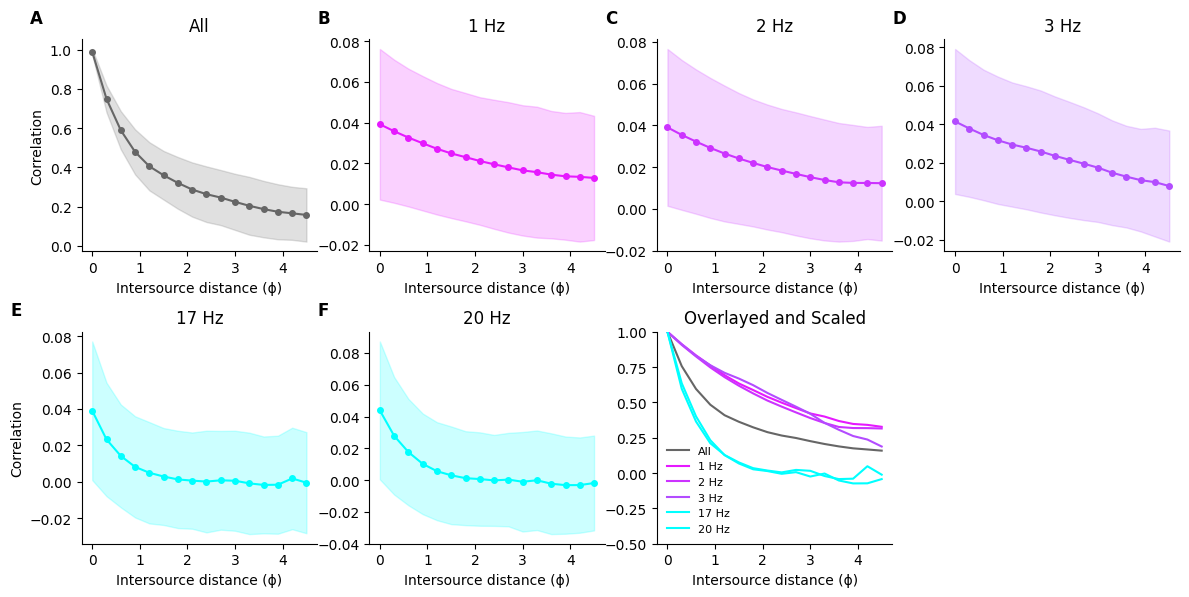

shp
Mapped frequencies [ 1  2  3 17 20] Hz to indices [1, 2, 3, 17, 20].


Wrote figs/boxcar/1s/corr_components_shp.pdf.


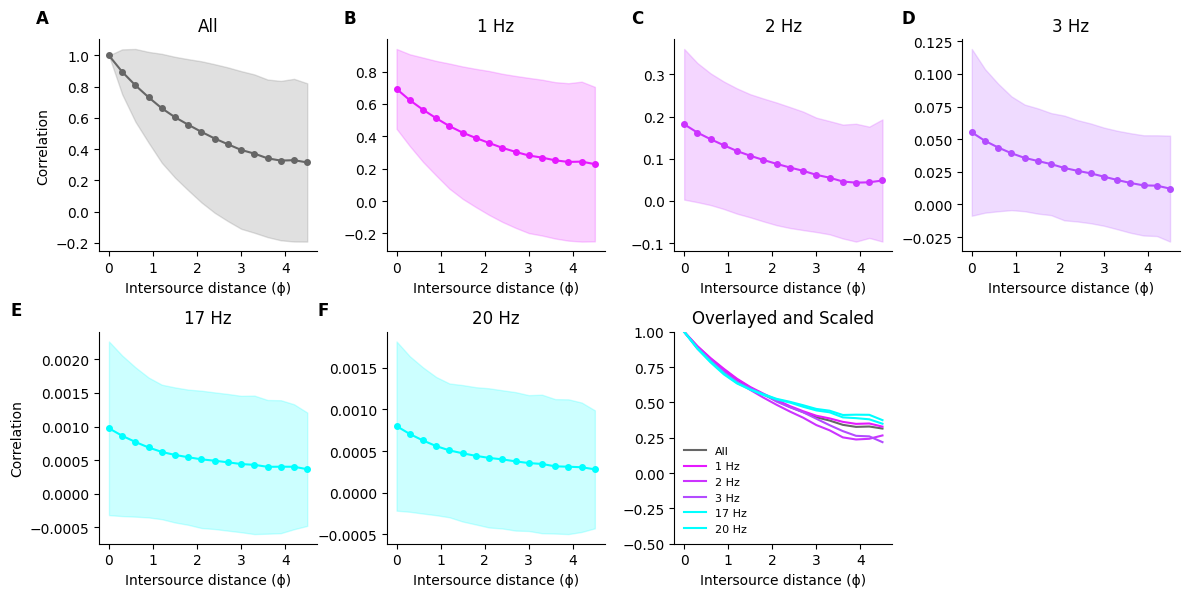

In [268]:
reload(fpf)
xlims_  = defaultdict(lambda: DEFAULT) #{"su_high":DEFAULT, "su":DEFAULT, "bw":DEFAULT, "cr":DEFAULT}
xticks_ = defaultdict(lambda: DEFAULT) #{"su_high":DEFAULT, "su":DEFAULT, "bw":DEFAULT, "cr":DEFAULT}
for k, F in data.items():
    which_freqs = ([1,2,3,17,20] if k.startswith("su_high") else [1,2,3,17,20]) * UNITS.Hz
    labs = [f"{f}" for f in which_freqs]
    cols = {"All":cm.gray(0.4)}; cols.update({l:col for l,col in zip(labs, [cm.cool(1 - f.magnitude/10) for f in which_freqs])})    
    print(k)
    slices = {"All":slice(1,10000)}
    freq_inds = F.freqs2inds(which_freqs)
    print(f"Mapped frequencies {which_freqs} to indices {freq_inds}.")
    slices.update({l:slice(fi, fi+1) for l, fi in zip(labs, freq_inds)})
    ax = fpf.plot_correlations(F.rho[iprb], F.pitch.to("um").magnitude, slices=slices, cols=cols, n_rows = 2, plot_order = ["All"] + labs)
    [(axi.set_xlabel(f"Intersource distance ({fpf.pitch_sym})"),
      not isdefault(xlims_[k])  and axi.set_xlim(xlims_[k]),
      not isdefault(xticks_[k]) and axi.set_xticks(xticks_[k])) for axi in ax]    
    file_name = f"{fig_dir_wnd_shp_len}/corr_components_{k}.pdf"
    fpft.label_axes(ax, "ABCDEF", fontsize=12, fontweight="bold", dy=-0.01)
    ax[-1].set_ylim(-0.5,1)
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."))
    sys.stdout.flush(); plt.show()

# The Multivariate Gaussian Fits

16Ts
Mapped 5 Hz to index 5.


Wrote figs/boxcar/1s/coef_vs_coef_16Ts_5Hz.pdf.


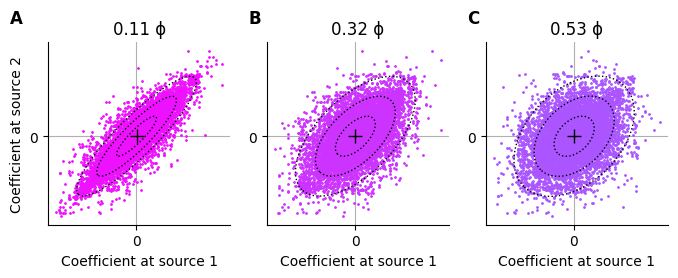

bw
Mapped 5 Hz to index 5.


Wrote figs/boxcar/1s/coef_vs_coef_bw_5Hz.pdf.


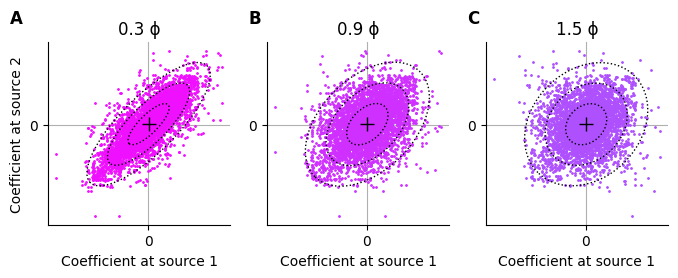

s=p
Mapped 5 Hz to index 5.


Wrote figs/boxcar/1s/coef_vs_coef_s=p_5Hz.pdf.


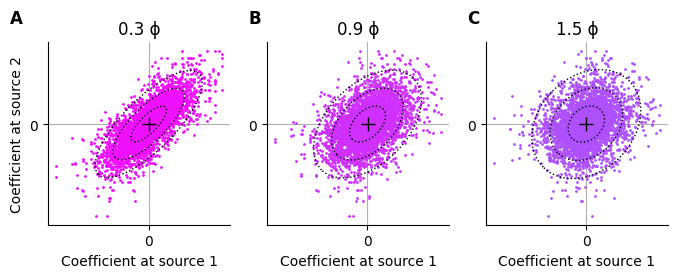

shp
Mapped 5 Hz to index 5.


Wrote figs/boxcar/1s/coef_vs_coef_shp_5Hz.pdf.


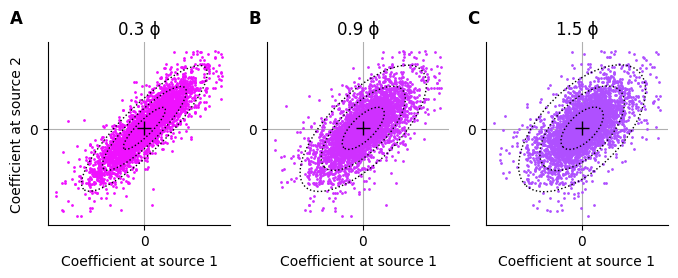

shw
Mapped 5 Hz to index 5.


Wrote figs/boxcar/1s/coef_vs_coef_shw_5Hz.pdf.


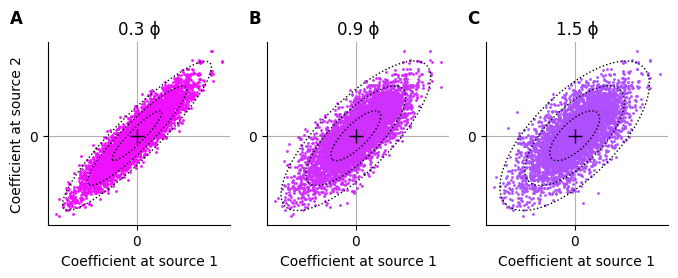

In [269]:
reload(fpf)
which_freqs = dict_update_from_field({"bw":5 * UNITS.hertz, "cr":5 * UNITS.hertz}, su_ds + ["16Ts"], "bw");  which_freqs["16T"]  = which_freqs["bw"]
which_idists= dict_update_from_field({"bw":[0,2,4],         "cr":[8,12,18]},       su_ds + ["16Ts"], "bw");  which_idists["16T"] = which_idists["bw"]
dcol_scales = dict_update_from_field({"bw":120000,          "cr":80000},           su_ds + ["16Ts"], "bw");  dcol_scales["16T"]  = dcol_scales["bw"]
for name, F in sorted(data.items()):
    print(name)
    which_freq = which_freqs[name]
    ifreq = F.freqs2inds([which_freq])[0]
    print(f"Mapped {which_freq} to index {ifreq}.")
    ax = fpf.plot_coef1_vs_coef2([F.ss[iprb], F.cc[iprb]],
                                 ifreq,
                                 F.pairs_um,
                                 F.pitch_string,                                 
                            i_pos_dists_to_plot = which_idists[name],
                            dist_col_scale = dcol_scales[name]
    )
    fpft.label_axes(ax, "ABC", fontsize=12, fontweight="bold", dy=-0.01)            
    file_name = f"{fig_dir_wnd_shp_len}/coef_vs_coef_{name}_{which_freq.magnitude}Hz.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()

### Supplementary Information

Wrote figs/boxcar/1s/coefs_and_traces_16Ts_5Hz.pdf.


<Figure size 800x300 with 0 Axes>

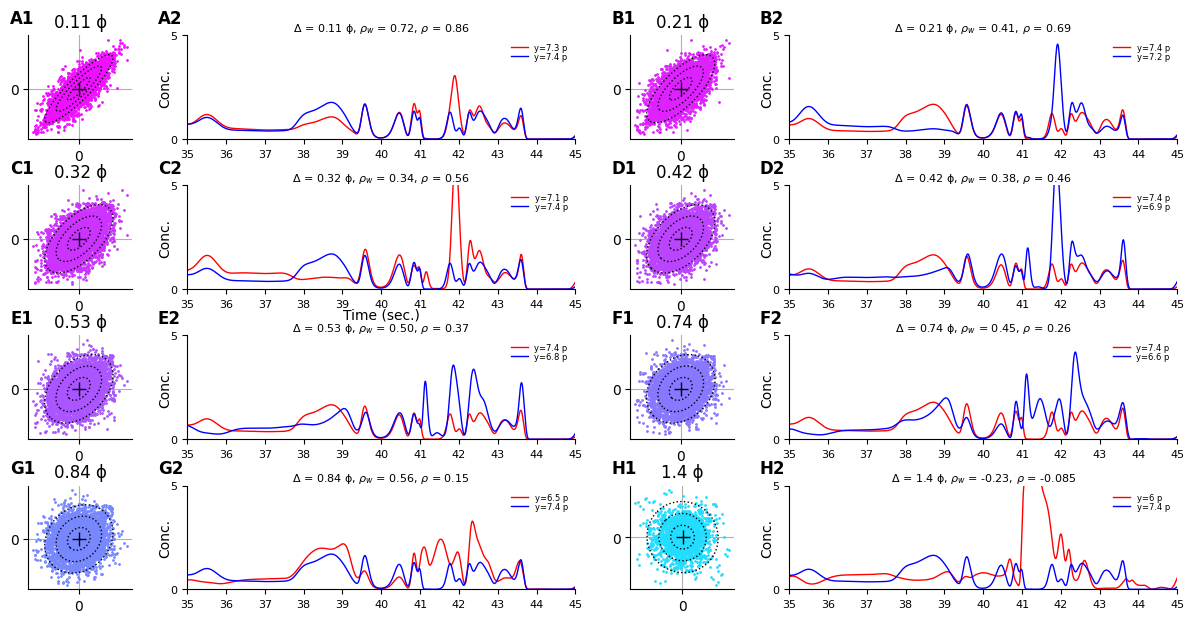

Wrote figs/boxcar/1s/coefs_and_traces_bw_5Hz.pdf.


<Figure size 800x300 with 0 Axes>

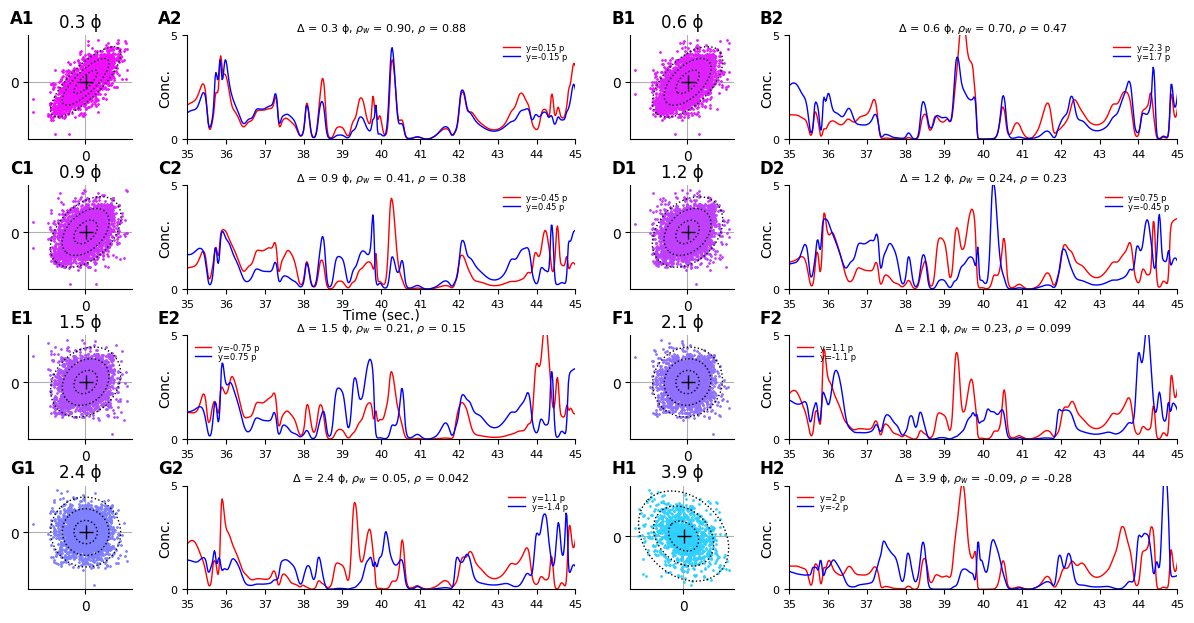

In [270]:
reload(fpf)
reload(fpft)
freq      = dict_update_from_field({"bw":5 * UNITS.hertz,          "cr":5 * UNITS.hertz},        su_ds + ["16Ts", "16T"], "bw"); 
idists    = dict_update_from_field({"bw":[0,1,2,3,4,6,7,12],       "cr":[0,4,8,12,16,20,21,22]}, su_ds + ["16Ts", "16T"], "bw"); 
t_lim     = dict_update_from_field({"bw":[35, 45]*UNITS.sec,       "cr":[39.5,40.5]*UNITS.sec,  "16T":[9.5,10.5]*UNITS.sec},  su_ds + ["16Ts"], "bw")
dt        = dict_update_from_field({"bw":1*UNITS.sec,              "cr":0.25*UNITS.sec},         su_ds + ["16Ts"], "bw", ["16T"], "cr");
for k, F in sorted(data.items()):
    if surrQ(k): continue
    figure(figsize=(12,6))
    coef_ax, trace_ax = fpf.plot_coef_vs_coef_and_traces(F, freq[k], idists[k],
                                                         which_probe = iprb, n_per_row = 2,
                                                         y_lim=[0,5] if k[:2]!="su" else [-3,3],
                                                         t_lim = t_lim[k],
                                                         dt = dt[k])
    for ax in coef_ax:
        ax.set_xlabel("")
        ax.set_ylabel("")
    [ax.legend(fontsize=6,labelspacing=0,frameon=False) for ax in trace_ax]
    tight_layout(pad=0)
    all_ax = bsum([[ax_c, ax_t] for ax_c, ax_t in zip(coef_ax, trace_ax)], [])
    n_ax   = len(all_ax)
    fpft.label_axes(all_ax,
                    [ch+nu for ch in "ABCDEFGH" for nu in "12"],
                    align_x = [list(range(i,n_ax,4)) for i in range(4)],
                    align_y = [list(range(i,i+4)) for i in range(0,n_ax,4)],
                    fontsize=12, fontweight="bold", dy=-0.01)
    file_name = f"{fig_dir_wnd_shp_len}/coefs_and_traces_{k}_{freq[k].to(UNITS.hertz).magnitude}Hz.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()

# Asymmetric Laplacian Fits

/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:314: RuntimeWarning: divide by zero encountered in log10
  INFO(f"{d=:3d} @ Freq # {which_ifreq:3d}: -np.log10(p) = {-np.log10(F.pvals[which_probe][d][0][which_ifreq]):1.3f}")
      fisher_plumes_figs 2023/07/08 15:18:18     INFO: d=8000 @ Freq #   1: -np.log10(p) = inf


      fisher_plumes_figs 2023/07/08 15:18:18     INFO: d=16000 @ Freq #   1: -np.log10(p) = 291.499


      fisher_plumes_figs 2023/07/08 15:18:18     INFO: d=24000 @ Freq #   1: -np.log10(p) = 237.976


16Ts
Setting extent to [-0.5, 15.5, 0.5, 20.5].


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Wrote figs/boxcar/1s/alap_fits_16Ts_1Hz.pdf.


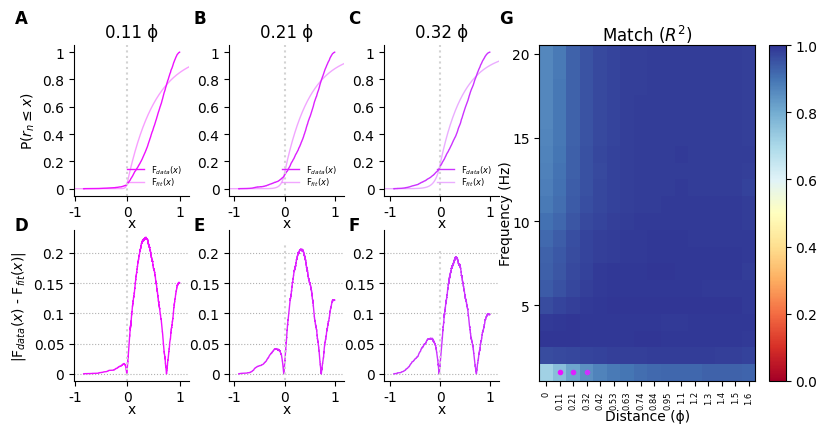

      fisher_plumes_figs 2023/07/08 15:18:19     INFO: d=8000 @ Freq #   5: -np.log10(p) = 40.405


      fisher_plumes_figs 2023/07/08 15:18:19     INFO: d=16000 @ Freq #   5: -np.log10(p) = 29.378


      fisher_plumes_figs 2023/07/08 15:18:19     INFO: d=24000 @ Freq #   5: -np.log10(p) = 18.867


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Setting extent to [-0.5, 15.5, 0.5, 20.5].


Wrote figs/boxcar/1s/alap_fits_16Ts_5Hz.pdf.


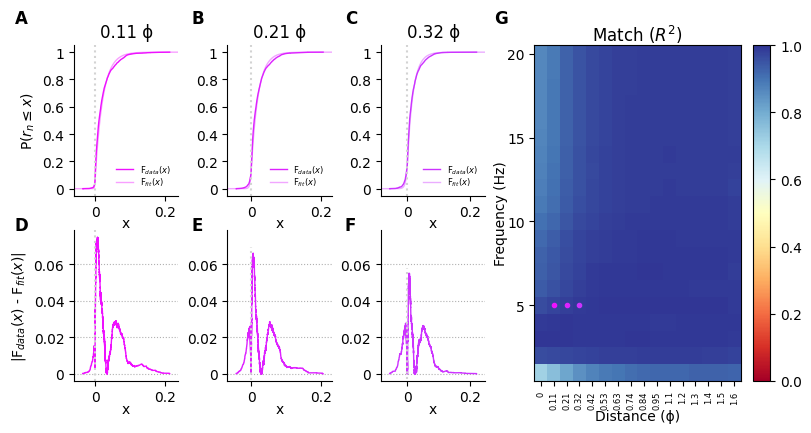

      fisher_plumes_figs 2023/07/08 15:18:20     INFO: d=8000 @ Freq #  10: -np.log10(p) = 133.302


      fisher_plumes_figs 2023/07/08 15:18:20     INFO: d=16000 @ Freq #  10: -np.log10(p) = 91.863


      fisher_plumes_figs 2023/07/08 15:18:20     INFO: d=24000 @ Freq #  10: -np.log10(p) = 59.701


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Setting extent to [-0.5, 15.5, 0.5, 20.5].


Wrote figs/boxcar/1s/alap_fits_16Ts_10Hz.pdf.


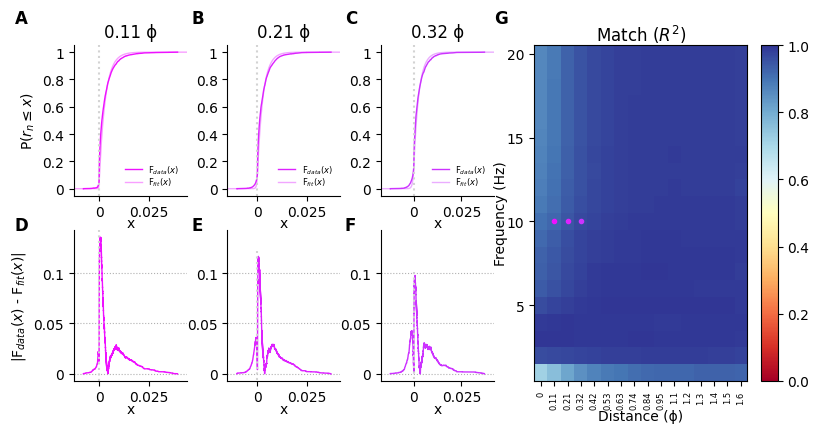

      fisher_plumes_figs 2023/07/08 15:18:22     INFO: d=7500 @ Freq #   1: -np.log10(p) = 142.277


bw


      fisher_plumes_figs 2023/07/08 15:18:22     INFO: d=15000 @ Freq #   1: -np.log10(p) = 105.410


      fisher_plumes_figs 2023/07/08 15:18:22     INFO: d=22500 @ Freq #   1: -np.log10(p) = 75.585


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Setting extent to [-0.5, 15.5, 0.5, 20.5].


Wrote figs/boxcar/1s/alap_fits_bw_1Hz.pdf.


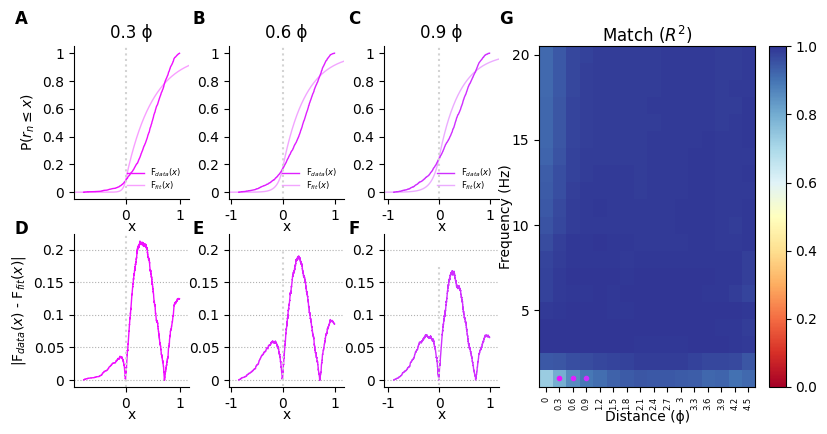

      fisher_plumes_figs 2023/07/08 15:18:23     INFO: d=7500 @ Freq #   5: -np.log10(p) = 3.393


      fisher_plumes_figs 2023/07/08 15:18:23     INFO: d=15000 @ Freq #   5: -np.log10(p) = 1.215


      fisher_plumes_figs 2023/07/08 15:18:23     INFO: d=22500 @ Freq #   5: -np.log10(p) = 1.713


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Setting extent to [-0.5, 15.5, 0.5, 20.5].


Wrote figs/boxcar/1s/alap_fits_bw_5Hz.pdf.


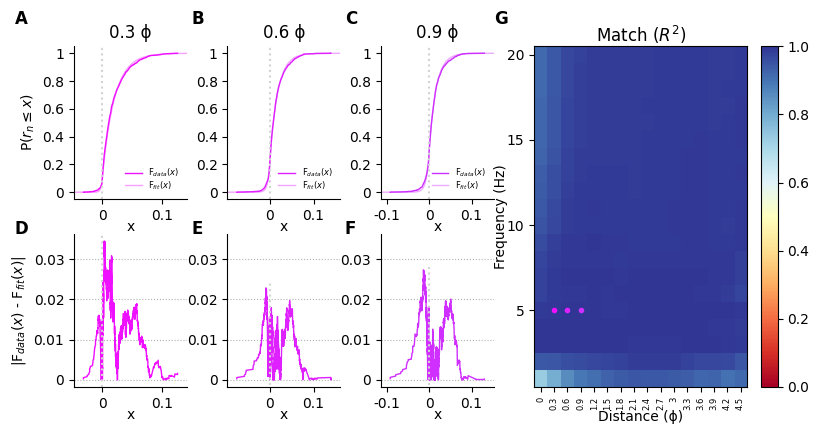

      fisher_plumes_figs 2023/07/08 15:18:25     INFO: d=7500 @ Freq #  10: -np.log10(p) = 29.570


      fisher_plumes_figs 2023/07/08 15:18:25     INFO: d=15000 @ Freq #  10: -np.log10(p) = 12.817


      fisher_plumes_figs 2023/07/08 15:18:25     INFO: d=22500 @ Freq #  10: -np.log10(p) = 8.230


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Setting extent to [-0.5, 15.5, 0.5, 20.5].


Wrote figs/boxcar/1s/alap_fits_bw_10Hz.pdf.


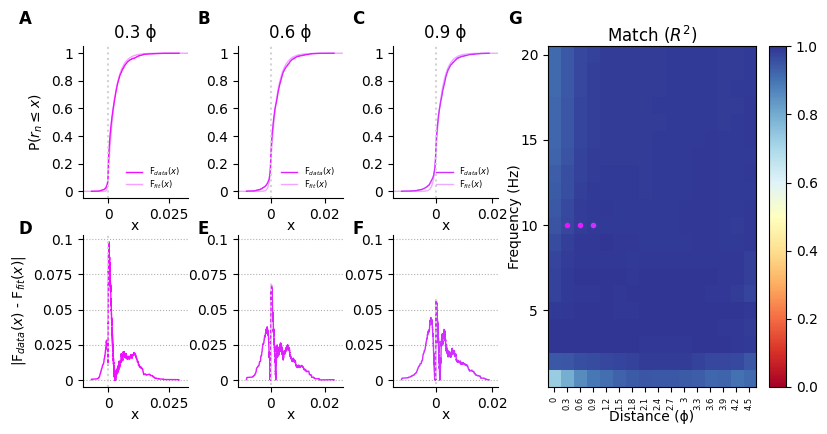

In [271]:
reload(fpft)
reload(fpf)
idist     = dict_update_from_field({"bw":[1,2,3],          "cr":[1,13,15]},         su_ds + ["16Ts"], "bw", ["16T"],"cr")
freq_max  = dict_update_from_field({"bw":21 * UNITS.hertz, "cr":101 * UNITS.hertz}, su_ds + ["16Ts"], "bw", ["16T"],"cr")
vmin      = dict_update_from_field({"bw":[0,0.0],          "cr":[0,0.5]},           su_ds + ["16Ts"], "bw", ["16T"],"cr")
vmax      = dict_update_from_field({"bw":[50,1],           "cr":[10,1]},            su_ds + ["16Ts"], "bw", ["16T"],"cr")
plot_pvals= False
for name, F in sorted(data.items()):
    if surrQ(name): continue
    print(name)
    d = np.array(list(F.rho[iprb].keys()))
    d = np.sort(d[d>=0])
    for f in [1, 5, 10] * UNITS.hertz:
        which_freq = defaultdict(lambda: f)
        ax_cdf, ax_dcdf, ax_hm = fpf.plot_alaplace_fits(F, d[idist[name]],
                                                        which_probe = iprb,
                               ifreq_lim = [1, F.freqs2inds([freq_max[name]])[0]],
                               which_ifreq = F.freqs2inds([which_freq[name]])[0],
                                                        figsize=(8,4),
                                                        vmax=vmax[name],
                                                        vmin=vmin[name],
                                                        plot_dvals=True,
                                                        plot_pvals=plot_pvals)
        tight_layout(pad=0)
        fpft.label_axes(ax_cdf + ax_dcdf + ax_hm, "ABCDEFGHIJK",
                        align_y = [[0,1,2,6],[3,4,5,7]] if plot_pvals else [[0,1,2],[3,4,5]],
                        align_x = [[0,3],[1,4],[2,5]],
                        fontsize=12, fontweight="bold", dy=0)
        file_name = f"{fig_dir_wnd_shp_len}/alap_fits_{name}_{which_freq[name].to(UNITS.hertz).magnitude}Hz.pdf"
        SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
        sys.stdout.flush(); plt.show()

# Plot the figure showing λ(s)

/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/colors.py:710: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  xa = np.array(X, copy=True)
      fisher_plumes_figs 2023/07/08 15:18:26     INFO: plot_gen_exp_paramter_fits_panel with which_fis=[1, 3, 7, 10], log_scale=True.


Wrote figs/boxcar/1s/fit_k=True/la_vs_s_fits_16Ts.pdf.


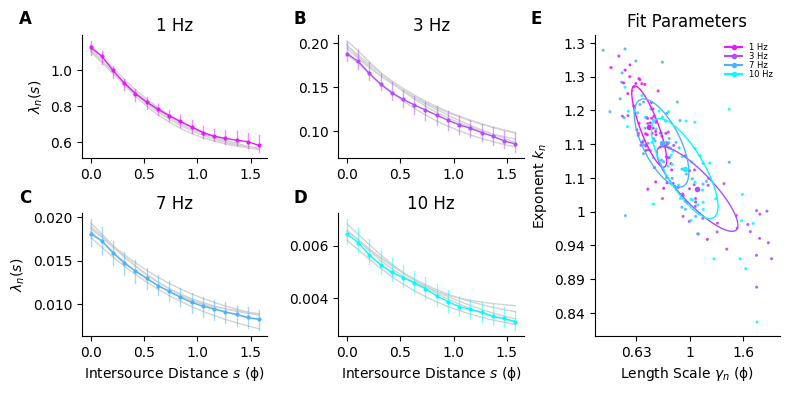

/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/colors.py:710: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  xa = np.array(X, copy=True)
      fisher_plumes_figs 2023/07/08 15:18:27     INFO: plot_gen_exp_paramter_fits_panel with which_fis=[1, 3, 7, 10], log_scale=True.


Wrote figs/boxcar/1s/fit_k=True/la_vs_s_fits_bw.pdf.


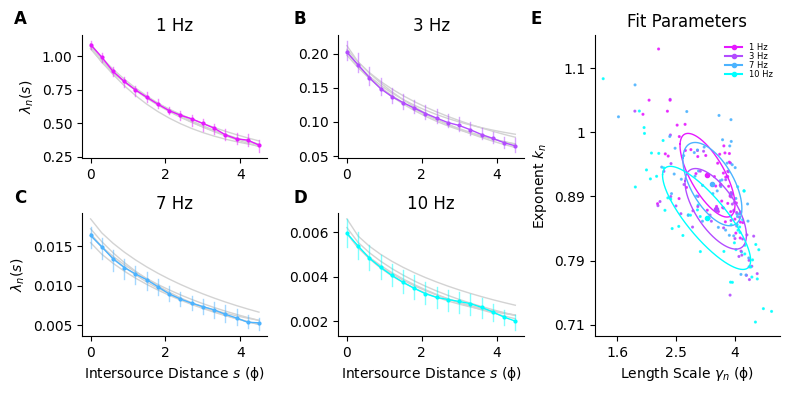

In [272]:
reload(fpft)
reload(fpf)
freqs  = dict_update({fld:[1,3,7,10] * UNITS.hertz for fld in ["bw", "cr", "su", "16T", "16Ts"]}, ["su_high_white", "su_high_pink", "su_high2_pink", "su_white"], [[1,3,17,20] * UNITS.hertz]*4)
xl     = dict_update_from_field({"bw":(-10,200),                 "cr": (-2, 50)},                    su_ds + ["16Ts"], "bw", ["16T"], "cr")
xt     = dict_update_from_field({"bw":arange(0,201,50),          "cr": arange(0,101,25)},            su_ds + ["16Ts"], "bw", ["16T"], "cr")
xtp    = dict_update_from_field({"bw":np.array([60,90,135]),     "cr": np.array([40,60, 90, 135])},  su_ds + ["16Ts"], "bw", ["16T"], "cr")
ytp    = dict_update_from_field({"bw":np.array([0.8,1,1.2,1.5]), "cr": np.array([0.8,1,1.2,1.5,2])}, su_ds + ["16Ts"], "bw", ["16T"], "cr")

#print(f"{wnd_key=:}")
#data_wnd = {k:v[wnd_key] for k,v in proc.items() if wnd_key in v and k != "su_high_pink"}
for k, F in sorted(data.items()):
    if surrQ(k): continue
    ax = fpf.plot_la_gen_fits_vs_distance(F, 
                                          figsize=(8,4), legloc = 'right',
                                          log_scale = True,
                                          scatter_size=1.5,
                                          which_ifreqs = F.freqs2inds(freqs[k]))
    [((i>1) and axi.set_xlabel(f"Intersource Distance $s$ ({fpf.pitch_sym})")) for i, axi in enumerate(ax[:4])]
    tight_layout(h_pad=1,w_pad=0.5)
    fpft.label_axes(ax, "ABCDEFGHIJK",
                    align_y = [[0,1,4],[2,3]],
                    align_x = [[0,2],[1,3]],
                    fontsize=12, fontweight="bold", dy=-0.02)                        
    file_name = f"{fig_dir_full}/la_vs_s_fits_{k}.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()

# Plot the Fisher Information

      fisher_plumes_figs 2023/07/08 15:18:29     INFO: dd[0]=100, dd[-1]=125000 (0.00131579, 1.64474 ϕ)


      fisher_plumes_figs 2023/07/08 15:18:29     INFO: Plotting which_ifreqs=[1, 2, 5, 10, 20].


16Ts


Wrote figs/boxcar/1s/fit_k=True/fisher_info_16Ts.pdf.


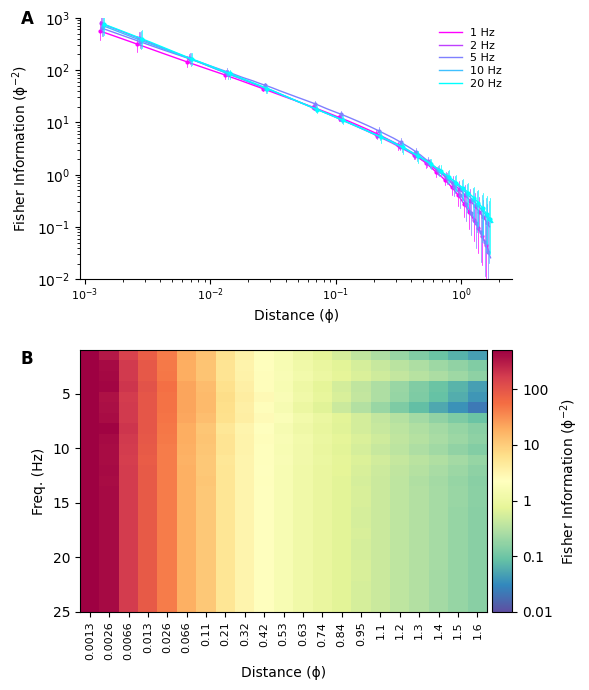

      fisher_plumes_figs 2023/07/08 15:18:31     INFO: dd[0]=100, dd[-1]=125000 (0.004, 5 ϕ)


      fisher_plumes_figs 2023/07/08 15:18:31     INFO: Plotting which_ifreqs=[1, 2, 5, 10, 20].


bw


Wrote figs/boxcar/1s/fit_k=True/fisher_info_bw.pdf.


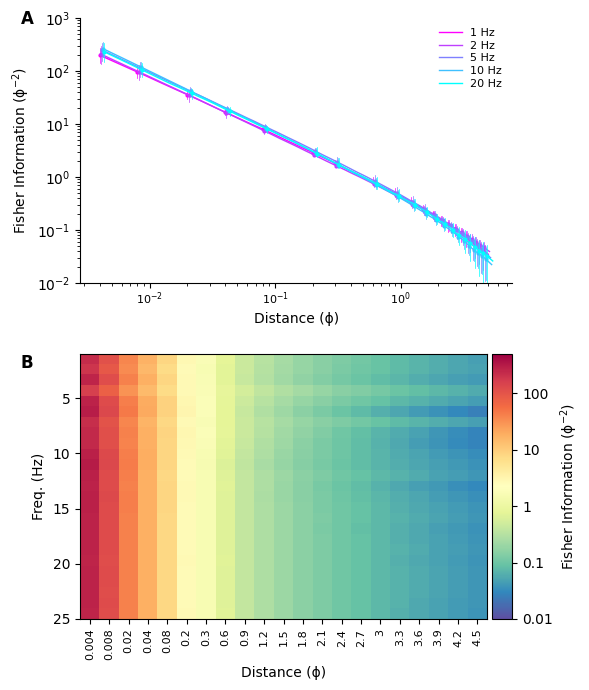

      fisher_plumes_figs 2023/07/08 15:18:32     INFO: dd[0]=100, dd[-1]=125000 (0.004, 5 ϕ)


      fisher_plumes_figs 2023/07/08 15:18:32     INFO: Plotting which_ifreqs=[1, 2, 5, 10, 20].


s=p


Wrote figs/boxcar/1s/fit_k=True/fisher_info_s=p.pdf.


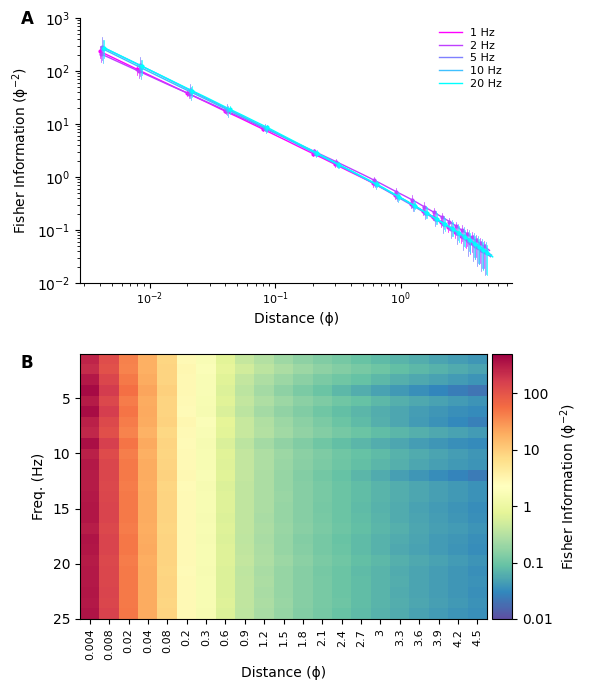

      fisher_plumes_figs 2023/07/08 15:18:34     INFO: dd[0]=100, dd[-1]=125000 (0.004, 5 ϕ)


      fisher_plumes_figs 2023/07/08 15:18:34     INFO: Plotting which_ifreqs=[1, 2, 5, 10, 20].


shp


Wrote figs/boxcar/1s/fit_k=True/fisher_info_shp.pdf.


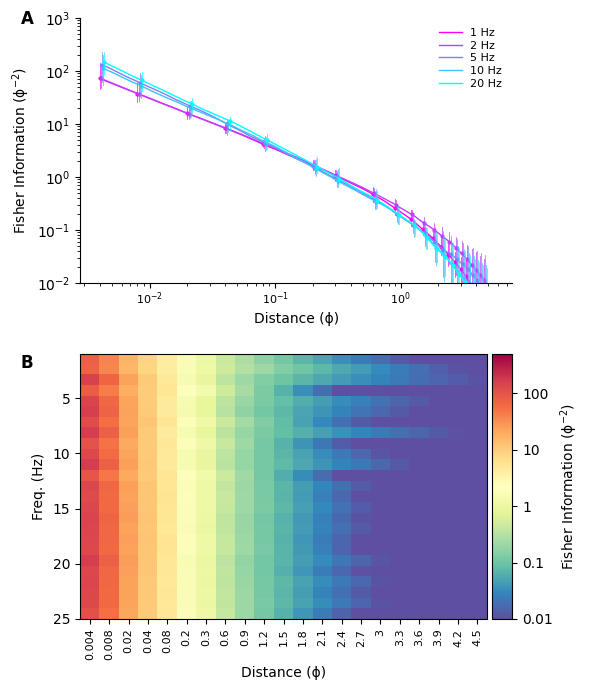

      fisher_plumes_figs 2023/07/08 15:18:35     INFO: dd[0]=100, dd[-1]=125000 (0.004, 5 ϕ)


      fisher_plumes_figs 2023/07/08 15:18:35     INFO: Plotting which_ifreqs=[1, 2, 5, 10, 20].


shw


Wrote figs/boxcar/1s/fit_k=True/fisher_info_shw.pdf.


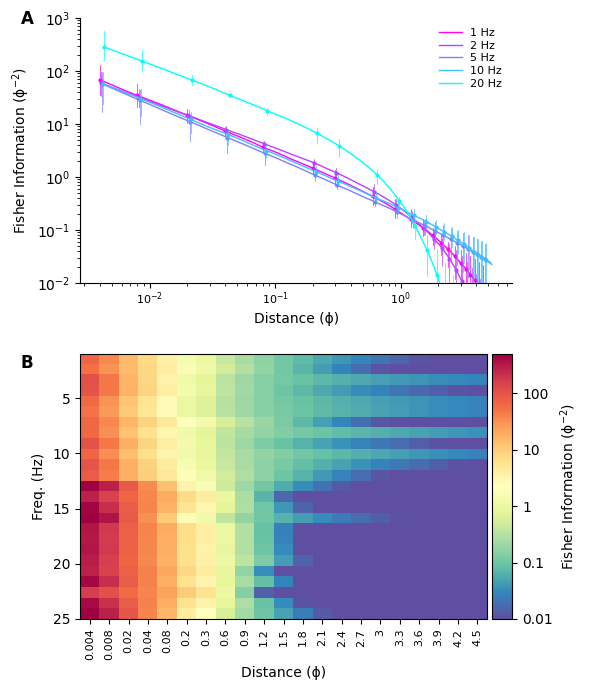

In [273]:
reload(fpt)
reload(fpft)
reload(fpf)
freqs     = dict_update_from_field({"cr":[5,10,20,50,100] * UNITS.hertz, "bw":[1,2, 5, 10, 20] * UNITS.hertz}, su_ds + ["16Ts"], "bw", ["16T"], "cr")
freq_max  = dict_update_from_field({"bw":25 * UNITS.hertz, "cr":100 * UNITS.hertz}, su_ds + ["16Ts"], "bw", ["16T"], "cr")
colscale  = dict_update_from_field({"bw":10,               "cr":40},                su_ds + ["16Ts"], "bw", ["16T"], "cr")
d_vals_um = dict_update_from_field({"bw":[1,5,50],         "cr":[0.1,10,70]},       su_ds + ["16Ts"], "bw", ["16T"], "cr")
d_lim_um  = dict_update_from_field({"bw":[100, 125000 ],   "cr":[100, 125000]},     su_ds + ["16Ts"], "bw", ["16T"], "cr")
bf_ytick  = dict_update_from_field({"bw":[0,5,10],         "cr":[0,50,100]},        su_ds + ["16Ts"], "bw", ["16T"], "cr")
bf_yl     = dict_update_from_field({"bw":[0,15],           "cr":[-5,100]},          su_ds + ["16Ts"], "bw", ["16T"], "cr")
plot_param_fits = False
for k, F in sorted(data.items()):
    print(k)
    figure(figsize=(6,7))
    ax_fisher, ax_best_freq, ax_d = fpf.plot_fisher_information(F,
                                                                which_probe = iprb,
                                                                d_lim_um   = d_lim_um[k],
                                                                d_vals_um  = np.array(d_vals_um[k])*1000,
                                                                d_space_fun  = lambda d0,d1,n:np.logspace(log10(d0),log10(d1),n),
                                                                which_ifreqs = F.freqs2inds(freqs[k]),
                                                                x_stagger = lambda x, i: x*(1.02**i),
                                                                plot_fun = plt.loglog,
                                                                log_scale = True,
                                                                plot_param_fits = plot_param_fits,
                                                                freq_max  = freq_max[k],
                                                                colfun    = lambda f: cm.cool_r(f/colscale[k]),
                                                                info_heatmap = True,
                                                                heatmap_range =[-2, log10(500)],
                                                                heatmap_cm    =cm.Spectral_r,
                                                                #bf_ytick  = bf_ytick[k],
    )
    ax_fisher.set_ylim(1e-2,1e3)
    tight_layout(h_pad=2,w_pad=0)
    fpft.label_axes([ax_fisher, ax_best_freq] + ax_d , "ABCDEFGHIJK",
                    #align_y = [[2,3,4]],
                    align_x = [[0,1,2] if plot_param_fits else [0,1]],
                    fontsize=12, fontweight="bold", dy=-0.02)
    #ax_best_freq.set_ylim(bf_yl[k])
    file_name = f"{fig_dir_full}/fisher_info_{k}.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()
    

# Plot Fisher information heatmaps together

Wrote figs/fit_k=True/fisher_info_heatmaps.pdf.


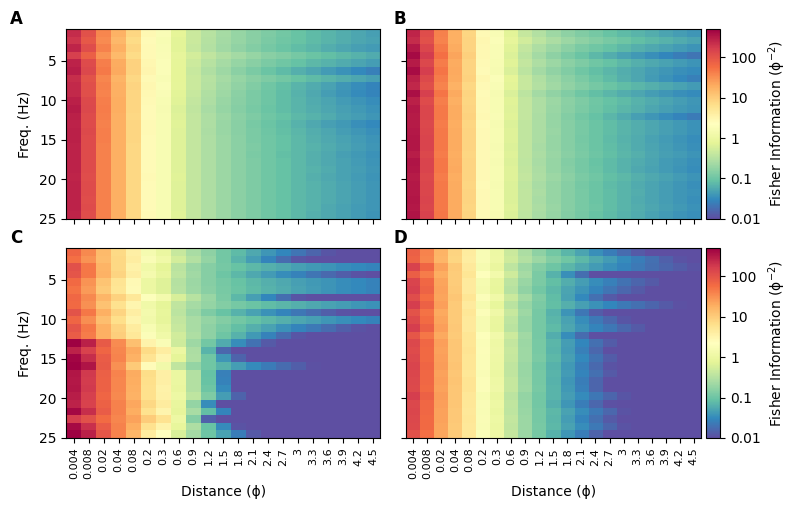

In [274]:
figure(figsize=(8,5))
gs = GridSpec(2,2)
order = ["bw", "s=p", "shw", "shp"]
which_wnd = (1 * UNITS.s, 'boxcar')
axes, cbs = [], []
for o, gsi in zip(order, gs):
    axes.append(subplot(gsi))
    axes[-1], cbi = fpf.plot_fisher_information_heatmap(data[o], 0, ax = axes[-1], freq_max = freq_max[o],
                                                        heatmap_range =[-2, log10(500)],
                                                        heatmap_cm    =cm.Spectral_r,
                                                        do_colorbar   = gsi.is_last_col(),
    )
    if gsi.is_first_row():
        axes[-1].tick_params(labelbottom=False)
        axes[-1].set_xlabel("")

    if not gsi.is_first_col():
        axes[-1].tick_params(labelleft = False)
        axes[-1].set_ylabel("")
tight_layout(w_pad = 1.5, h_pad=1.5)
fpft.label_axes(axes, "ABCD",
                align_y = [[0,1],[2,3]],
                align_x = [[0,2],[1,3]],
                fontsize=12, fontweight="bold", dy=0.01, dx = -0.01)
file_name = f"{fig_dir_fitk}/fisher_info_heatmaps.pdf"
SAVEPLOTS and (savefig(file_name, bbox_inches='tight', pad_inches=0), flush(f"Wrote {file_name}."));
sys.stdout.flush(); plt.show()
        

# Main figure showing effect of windowing

In [275]:
row_vals = ["s=p", "shp", "bw"]
col_vals = [(10 * UNITS.s, 'boxcar'), (1 * UNITS.s, 'hann'), (5 * UNITS.s, 'hann')]
data_grid= {(r,c):FisherPlumes(proc.load_data(init_filter=to_use[r], compute_filter = {"window_length":c[0], "window_shape":c[1], "fit_k":fit_k})[0], load_sims=False) for r in row_vals for c in col_vals}

                    proc 2023/07/08 15:18:39     INFO: Loading init_filter={'sim_name': 'surr_all_equal'} compute_filter={'window_length': <Quantity(10, 'second')>, 'window_shape': 'boxcar', 'fit_k': True} from proc/su.1/e58868247b3c6338.p


                    proc 2023/07/08 15:18:39     INFO: Returning 1 results.


           fisher_plumes 2023/07/08 15:18:39     INFO: Initializing from dictionary.


           fisher_plumes 2023/07/08 15:18:39     INFO: Attempting to copy data fields.


           fisher_plumes 2023/07/08 15:18:39     INFO: Copied 33 data fields from supplied dictionary.


                    proc 2023/07/08 15:18:39     INFO: Loading init_filter={'sim_name': 'surr_all_equal'} compute_filter={'window_length': <Quantity(1, 'second')>, 'window_shape': 'hann', 'fit_k': True} from proc/su.1/41e194271bf77f2f.p


                    proc 2023/07/08 15:18:39     INFO: Returning 1 results.


           fisher_plumes 2023/07/08 15:18:39     INFO: Initializing from dictionary.


           fisher_plumes 2023/07/08 15:18:39     INFO: Attempting to copy data fields.


           fisher_plumes 2023/07/08 15:18:39     INFO: Copied 33 data fields from supplied dictionary.


                    proc 2023/07/08 15:18:39     INFO: Loading init_filter={'sim_name': 'surr_all_equal'} compute_filter={'window_length': <Quantity(5, 'second')>, 'window_shape': 'hann', 'fit_k': True} from proc/su.1/d0364e19f217cda8.p


                    proc 2023/07/08 15:18:39     INFO: Returning 1 results.


           fisher_plumes 2023/07/08 15:18:39     INFO: Initializing from dictionary.


           fisher_plumes 2023/07/08 15:18:39     INFO: Attempting to copy data fields.


           fisher_plumes 2023/07/08 15:18:39     INFO: Copied 33 data fields from supplied dictionary.


                    proc 2023/07/08 15:18:39     INFO: Loading init_filter={'sim_name': 'surr_high', 'surrogate_k': 4} compute_filter={'window_length': <Quantity(10, 'second')>, 'window_shape': 'boxcar', 'fit_k': True} from proc/sup.1/baedabaaa47e54f4.p


                    proc 2023/07/08 15:18:40     INFO: Returning 1 results.


           fisher_plumes 2023/07/08 15:18:40     INFO: Initializing from dictionary.


           fisher_plumes 2023/07/08 15:18:40     INFO: Attempting to copy data fields.


           fisher_plumes 2023/07/08 15:18:40     INFO: Copied 33 data fields from supplied dictionary.


                    proc 2023/07/08 15:18:40     INFO: Loading init_filter={'sim_name': 'surr_high', 'surrogate_k': 4} compute_filter={'window_length': <Quantity(1, 'second')>, 'window_shape': 'hann', 'fit_k': True} from proc/sup.1/b63ba5e431b6bf4a.p


                    proc 2023/07/08 15:18:40     INFO: Returning 1 results.


           fisher_plumes 2023/07/08 15:18:40     INFO: Initializing from dictionary.


           fisher_plumes 2023/07/08 15:18:40     INFO: Attempting to copy data fields.


           fisher_plumes 2023/07/08 15:18:40     INFO: Copied 33 data fields from supplied dictionary.


                    proc 2023/07/08 15:18:40     INFO: Loading init_filter={'sim_name': 'surr_high', 'surrogate_k': 4} compute_filter={'window_length': <Quantity(5, 'second')>, 'window_shape': 'hann', 'fit_k': True} from proc/sup.1/ead8455231077f9b.p


                    proc 2023/07/08 15:18:40     INFO: Returning 1 results.


           fisher_plumes 2023/07/08 15:18:40     INFO: Initializing from dictionary.


           fisher_plumes 2023/07/08 15:18:40     INFO: Attempting to copy data fields.


           fisher_plumes 2023/07/08 15:18:40     INFO: Copied 33 data fields from supplied dictionary.


                    proc 2023/07/08 15:18:40     INFO: Loading init_filter={'sim_name': 'boulder16'} compute_filter={'window_length': <Quantity(10, 'second')>, 'window_shape': 'boxcar', 'fit_k': True} from proc/bw.1/75e68d0e5384bee3.p


                    proc 2023/07/08 15:18:41     INFO: Returning 1 results.


           fisher_plumes 2023/07/08 15:18:41     INFO: Initializing from dictionary.


           fisher_plumes 2023/07/08 15:18:41     INFO: Attempting to copy data fields.


           fisher_plumes 2023/07/08 15:18:41     INFO: Copied 33 data fields from supplied dictionary.


                    proc 2023/07/08 15:18:41     INFO: Loading init_filter={'sim_name': 'boulder16'} compute_filter={'window_length': <Quantity(1, 'second')>, 'window_shape': 'hann', 'fit_k': True} from proc/bw.1/a8fee270360a15c0.p


                    proc 2023/07/08 15:18:41     INFO: Returning 1 results.


           fisher_plumes 2023/07/08 15:18:41     INFO: Initializing from dictionary.


           fisher_plumes 2023/07/08 15:18:41     INFO: Attempting to copy data fields.


           fisher_plumes 2023/07/08 15:18:41     INFO: Copied 33 data fields from supplied dictionary.


                    proc 2023/07/08 15:18:41     INFO: Loading init_filter={'sim_name': 'boulder16'} compute_filter={'window_length': <Quantity(5, 'second')>, 'window_shape': 'hann', 'fit_k': True} from proc/bw.1/d62271d12bff5cab.p


                    proc 2023/07/08 15:18:41     INFO: Returning 1 results.


           fisher_plumes 2023/07/08 15:18:41     INFO: Initializing from dictionary.


           fisher_plumes 2023/07/08 15:18:41     INFO: Attempting to copy data fields.


           fisher_plumes 2023/07/08 15:18:41     INFO: Copied 33 data fields from supplied dictionary.


/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:731: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(I[ind_use]),


Wrote figs/fit_k=True/effect_of_windowing.pdf.


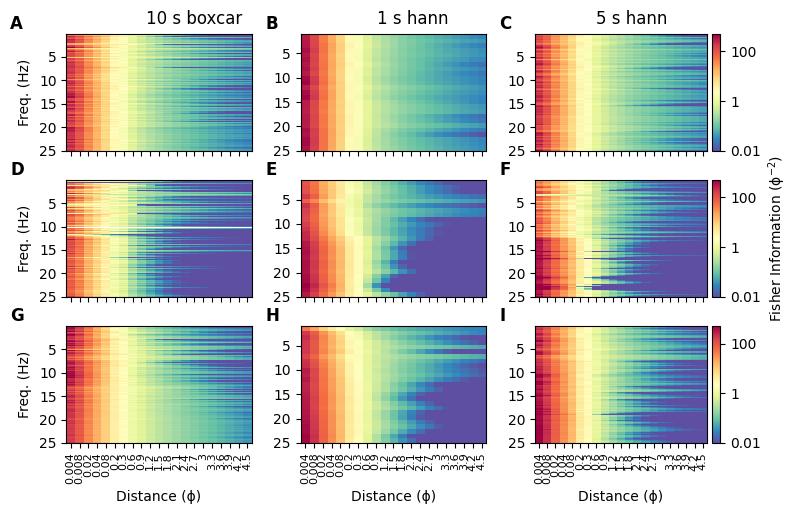

In [309]:
reload(fpf)
fig = figure(figsize=(8,5))
heatmap_range = defaultdict(lambda: [-2, log10(500)], {"bw":[-2,log10(500)], "su_high2_pink":[-2,log10(500)]})
gs       = GridSpec(len(row_vals), len(col_vals))
ax       = []
for i, ds in enumerate(row_vals):
    for j, ck in enumerate(col_vals):
        ax.append(subplot(gs[i,j]))
        p = data_grid[ds,ck]
        _, cb = fpf.plot_fisher_information_heatmap(
            p, 0, ax = ax[-1], heatmap_range = heatmap_range[ds],
            do_colorbar = gs[i,j].is_last_col(),
        )
        # Write text above each column
        
        if i == 0 :
            fx,fy = fig.transFigure.inverted().transform(ax[-1].transAxes.transform([0.5,0.5])) 
            print(fx,fy)
            fig.text(fx,1.0,f"{ck[0]} {utils.remove_non_alphanum(ck[1])}",va="center", ha="center", fontsize=12)
        if gs[i,j].is_last_col() and i!=1: cb.ax.set_ylabel("")
        if not gs[i,j].is_first_col(): ax[-1].set_ylabel("")
        if not gs[i,j].is_last_row():  [ax[-1].set_xlabel(""),ax[-1].set_xticklabels([])]
tight_layout(w_pad = 1.5, h_pad=1.5)
fpft.label_axes(ax, "ABCDEFGHI",
                align_y = [[0,1,2],[3,4,5],[6,7,8]],
                align_x = [[0,3,6],[1,4,7],[2,5,8]],
                fontsize=12, fontweight="bold", dy=0.01, dx = -0.01)
file_name = f"{fig_dir_fitk}/effect_of_windowing.pdf"
SAVEPLOTS and (savefig(file_name, bbox_inches='tight', pad_inches=0), flush(f"Wrote {file_name}."));
sys.stdout.flush(); plt.show()
        


# Length constants vs frequency

Wrote figs/boxcar/1s/fit_k=True/length_vs_freq_bw.pdf.


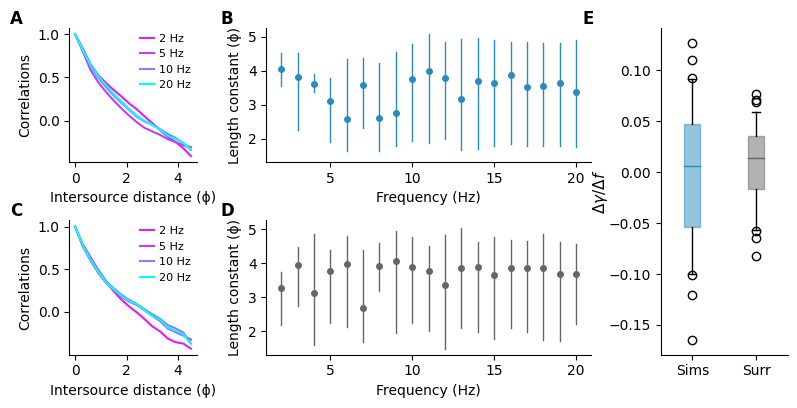

In [277]:
reload(fpf)
which_ds = ["bw","s=p"]
names = {"s=p":"Surrogate data", "bw":"Simulations", "16Ts":"Supplementary"}
labels  = {"s=p":"Surr", "bw":"Sims", "16Ts":"Supp"}
cols = {"s=p":cm.gray(0.4), "bw":cm.GnBu(0.75), "16Ts":cm.GnBu(0.25), }
gamma_plot_width = 2
gs = GridSpec(len(which_ds), 1+gamma_plot_width+1)
figure(figsize=(8,2 * len(which_ds)))
ax = []
which_corr_freqs = [2,5,10,20] * UNITS.Hz
labs = [f"{f}" for f in which_corr_freqs]
cols.update({l:col for l,col in zip(labs, [cm.cool(1 - f.magnitude/20) for f in which_corr_freqs])})
freq_min = (1/window_length.to(UNITS.s).magnitude) * UNITS.Hz
coef_γ_vs_freq = {}
for i, ds in enumerate(which_ds):
    F = data[ds]
    coef_γ_vs_freq[ds] = F.coef_γ_vs_freq[iprb]
    d_scale = F.pitch.to(UNITS.um).magnitude
    freq_inds = F.freqs2inds(which_corr_freqs)
    slices = {}    
    slices.update({l:slice(fi, fi+1) for l, fi in zip(labs, freq_inds)})    
    ax.append(subplot(gs[i,0]))
    fpf.plot_correlations(F.rho[0], F.pitch.to(UNITS.um).magnitude, slices = slices, cols = cols,
                          plot_slices = False, plot_overlay=True, ax = [ax[-1]],
                          legend_args = {"handlelength":1.25, "handletextpad":0.5, "borderpad":0},
                          
                          
    )
    ax[-1].set_xlabel(f"Intersource distance ({fpf.pitch_sym})")
    ax[-1].set_title("")
    ax[-1].set_yticks(np.arange(0,1.1,0.5))
    ax[-1].set_ylabel("Correlations")
    ax.append(subplot(gs[i,1:1+gamma_plot_width], sharey=None if not i else ax[1]))
    γbs = F.fit_params[0][1:][:,:,1]
    freq_max = F.freq_max
    freqs_γ  = F.freqs[:γbs.shape[1]]
    ind_use  = (freqs_γ > freq_min) & (freqs_γ <= freq_max)
    lo,md,hi = percentile(γbs, [5,50,95], axis = 0) / d_scale
    
    ax[-1].plot(freqs_γ[ind_use].to(UNITS.Hz).magnitude, md[ind_use], "o",color=cols[ds], markersize=4)
    ax[-1].plot([freqs_γ[ind_use].to(UNITS.Hz).magnitude]*2, [lo[ind_use], hi[ind_use]], color=cols[ds],linewidth=1)
    ax[-1].set_xlabel("Frequency (Hz)")
    ax[-1].set_ylabel(f"Length constant ({fpf.pitch_sym})")
    fpft.spines_off(ax[-1])

ax_γ = subplot(gs[:,-1])
box = ax_γ.boxplot(vstack([coef_γ_vs_freq[ds][:,-1] for ds in which_ds]).T, patch_artist=True,
                   widths=0.25, labels = [labels[dsi] for dsi in which_ds],
                   whis = [5,95],
                   
)
ax_γ.set_ylabel("$\Delta \gamma / \Delta f$", fontsize=11,labelpad=-1)
[setp(b, color = fpft.set_alpha(cols[ds],0.5), facecolor=fpft.set_alpha(cols[ds],0.5)) for ds, b in zip(which_ds, box["boxes"])]
[setp(b, color = cols[ds], linewidth=1) for ds, b in zip(which_ds, box["medians"])]
fpft.spines_off(ax_γ)
tight_layout(w_pad=0)

fpft.label_axes(ax + [ax_γ], "ABCDE",
                fontsize=12, fontweight="bold",
                dx = -0.01, dy=0.01,
                align_x = [[0,2],[1,3]],
                align_y = [[0,1,4]])

file_name = f"{fig_dir_full}/length_vs_freq_{which_ds[0]}.pdf"
SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
sys.stdout.flush(); plt.show()

# Regressing information on frequency

Wrote figs/boxcar/1s/fit_k=True/reg_coefs_16Ts.pdf.


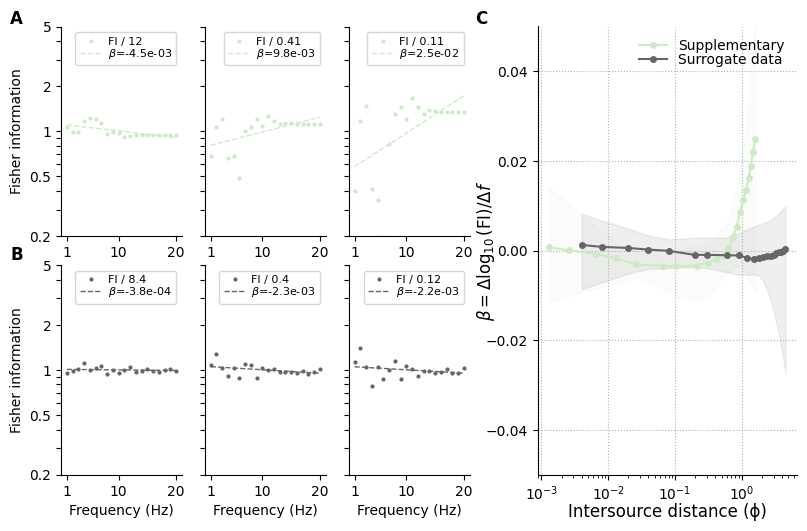

In [278]:
which_ds = ["16Ts", "s=p"]
which_log10_dists = defaultdict(lambda: [-1,0, log10(2)])
mean_normalize = True
same_plot = True
coef_plot_width = 2
gs = GridSpec(len(which_ds), len(which_log10_dists[which_ds[0]])+coef_plot_width)
figure(figsize=(8,2.5 * len(which_ds)))
ax = []
for i, ds in enumerate(which_ds):
    ax.append([])
    F = data[ds]
    I = F.I[iprb][0]
    I_freqs = F.freqs[:I.shape[0]]
    ind_use = (I_freqs >= F.reg_freq_range[0]) & (I_freqs <= F.reg_freq_range[1])
    xx = I_freqs[ind_use].to(UNITS.Hz).magnitude
    xe = linspace(min(xx),max(xx),101)    
    d_scale = F.pitch.to(UNITS.um).magnitude        
    dd = F.I_dists/d_scale
    which_idists = []
    for j, ddj in enumerate(which_log10_dists[ds]):
        which_idist = argmin(abs(dd - 10**ddj))
        which_idists.append(which_idist)
        ax[i].append(subplot(gs[i,j]))
        axij = ax[i][-1]
        
        yy = I[ind_use, which_idist]
        c0,c1 = F.reg_coefs[iprb][0][which_idist]
        ye = 10**(c0 + c1 * xe)
        ym = 10**mean(log10(yy * d_scale**2))
        axij.semilogy(xx, (yy * d_scale**2)/(ym**mean_normalize),
                      "o", markersize=2,
                      label=f"FI / {ym:.2g}",
                      color = cols[ds],
        )
        axij.plot(xe, (ye * d_scale**2)/(ym**mean_normalize), "--",
                  color=cols[ds], linewidth=1,
                  label = f"$\\beta$" + f"={c1:1.1e}"
        )
        mean_normalize and axij.set_ylim(0.2,5)
        axij.legend(frameon=True, fontsize=8, labelspacing=0, handletextpad=0.5)
        xt = list(axij.get_xticks())
        if xx[0] not in xt: xt = ([xx[0]] + xt[1:]) if xt[0] < xx[0] else ([xx[0]] + xt)
        axij.set_xticks(xt)
        axij.set_xlim(0, xx[-1]+1)
        if mean_normalize:
            yt = np.array(list(arange(0.2,1,0.1)) + list(range(1,6)))
            axij.set_yticks(yt, labels= [s if s[-1] in "125" else "" for s in [f"{yti:g}" for yti in yt]], fontsize=10)
        [axij.spines[w].set_visible(False) for w in ["right", "top"]]
        not gs[i,j].is_first_col() and axij.set_yticklabels([])
        gs[i,j].is_last_row() and axij.set_xlabel("Frequency (Hz)")
        gs[i,j].is_first_col() and axij.set_ylabel("Fisher information")
        
    if same_plot and gs[i,j].is_first_row(): ax_coef = subplot(gs[:,-coef_plot_width:])
    elif not same_plot: ax_coef = subplot(gs[i,-coef_plot_width:])
    else: pass # ax_coef will already have been defined.
    pc = percentile(F.reg_coefs[iprb][1:][:,:,-1],[5,50,95],axis=0)
    ax_coef.semilogx(dd, pc[1], "o-", color=cols[ds], markersize=4, label = names[ds])
    ax_coef.fill_between(dd, pc[0], pc[2],color=fpft.set_alpha(cols[ds],0.1))
#    ax_coef.semilogx(dd[which_idists], pc[1][which_idists], "o", color = "r", markersize=4)    
    ax_coef.set_ylim(-0.05,0.05)
    ax_coef.set_ylabel("$\\beta = \Delta \log_{10}($FI$)/\Delta f$",labelpad=-8, fontsize=12)
    ax_coef.set_xlabel(f"Intersource distance ({fpf.pitch_sym})",labelpad=0, fontsize=12)
    [ax_coef.spines[w].set_visible(False) for w in ["right", "top"]]
ax_coef.grid(True, linestyle=":")
ax_coef.legend(frameon=False, labelspacing =0)
tight_layout(pad=0,w_pad=0)

for i, axi in enumerate(ax):
    for j, axij in enumerate(axi):
        trans = mtransforms.Affine2D().translate(-0.06*j,0).scale(sx=1.25,sy=1)
        bbox  = axij.get_position()
        axij.set_position(mtransforms.TransformedBbox(bbox, trans))

fpft.label_axes([ax[0][0], ax[1][0], ax_coef], "ABC",
                fontsize=12, fontweight="bold",
                align_x = [[0,1]],
                align_y = [[0,2]])

file_name = f"{fig_dir_full}/reg_coefs_{which_ds[0]}.pdf"
SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
sys.stdout.flush(); plt.show()

# Information heatmaps as window size is changed

In [279]:
window_shapes_used  = lambda init_filter: sorted(list(set(m["compute"]["window_shape"] for m in proc.find_registry_matches(init_filter = init_filter, compute_filter={"fit_k":fit_k}))), 
                                                 key = lambda v: utils.remove_non_alphanum(str(v)))

In [280]:
[md.logger.setLevel(logging.WARNING) for md in [crick, boulder, surrogate, fp, proc]]

[None, None, None, None, None]

In [281]:
plot_series = False 
if plot_series:
    reload(fpf)
    heatmap_range = defaultdict(lambda: [-2, log10(500)], {"cr":[-2,2], "su_high_pink":[-2,2]})
    figsize       = defaultdict(lambda: (8,5), {"cr":(8,8)})
    for ds in data.keys():
        window_shapes = window_shapes_used(to_use[ds])
        if len(window_shapes)>1:
            for wnd_shp in window_shapes:
                series_data = {m["compute"]["window_length"]:FisherPlumes(d, load_sims=False) 
                               for d,m in zip(*proc.load_data(init_filter = to_use[ds], compute_filter={"fit_k":fit_k, "window_shape":wnd_shp}, return_matches=True))}
                fpf.plot_window_series(series_data, heatmap_range = heatmap_range[ds], figsize = figsize[ds])
                fig_dir = fpft.get_fig_dir(window_shape = wnd_shp, fit_k = fit_k, create = True)
                file_name = f"{fig_dir}/{ds}_series.pdf"
                SAVEPLOTS and (savefig(file_name, bbox_inches='tight', pad_inches=0), flush(f"Wrote {file_name}."));
                sys.stdout.flush(); plt.show()

# Compute the spectrum

In [282]:
Info = namedtuple('Info','name,color')
infos = {"16Ts": Info(name="Supp. dataset",               color = "dodgerblue"),
         "bw":   Info(name="Main dataset",                color = "orangered"),
         "s=p":  Info(name="Surrogate (all =, pink)",     color = "pink"),
         "shw":  Info(name="Surrogate (high>low, white)", color = "silver"),
         "shp":  Info(name="Surrogate (high>low, pink)",  color = "violet"),
}

Wrote figs/boxcar/1s/spectra.pdf.


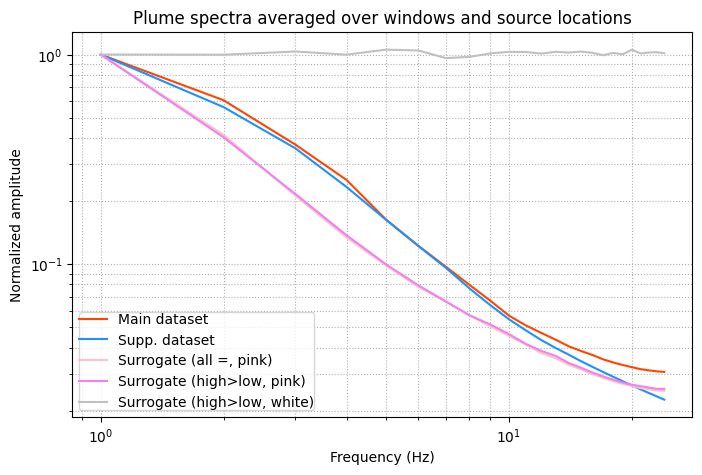

In [283]:
figure(figsize=(8,5))
for k in sorted(data, key=lambda x: infos[x].name):
    f = []
    for _, s in data[k].stft.items():
        fr, tt, S = s[0]
        f.append(np.abs(S))
        
    fs = F.fs.to("Hz").magnitude
    f = np.array(f)
    a = np.mean(f,axis=-1).mean(axis=0)    
    loglog(fr[fr<fs/2][1:],a[fr<fs/2][1:]/a[1],
           label=infos[k].name,
           color=infos[k].color)
legend(borderpad=0)
xlabel("Frequency (Hz)")
ylabel("Normalized amplitude")
title("Plume spectra averaged over windows and source locations")
grid(True, which='both', linestyle=":")
fig_dir = fpft.get_fig_dir(window_shape="boxcar", window_length=1*UNITS.s, create=True)
file_name = f"{fig_dir}/spectra.pdf"
SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));

# The End

# Sandbox

## Plot λ for random frequencies

/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/colors.py:710: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  xa = np.array(X, copy=True)


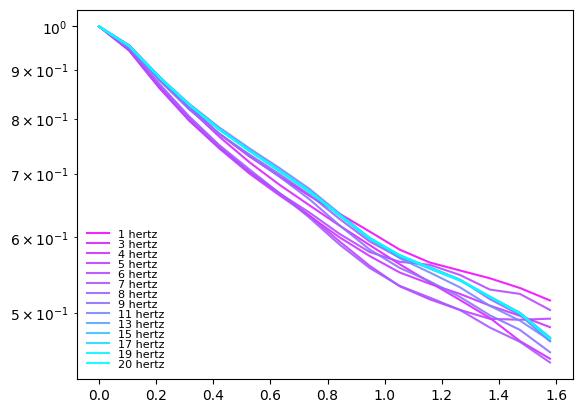

In [284]:
random.seed(1)
F = data["16Ts"]
d = np.array(list(F.la[0].keys()))/F.pitch.to(UNITS.um).magnitude
ibs = 0
la = np.array([F.la[0][ki][ibs] for ki in F.la[0]])
la1=la/la[0]
for i, f in zip(arange(la1.shape[1]), F.freqs):
    if f == 0 * UNITS.Hz: continue
    if f>20 * UNITS.Hz: break
    if rand()> 20/(len(F.freqs)*20/50): continue
    semilogy(d, la1[:, i], color = fpft.set_alpha(cm.cool_r(f/20 * UNITS.Hz),0.9), label = f"{f:g}");
#ylim(0.2,1)
legend(labelspacing=0, frameon=False, loc="lower left", fontsize=8)